# Capstone Story Telling - FEMA Data

    Originally, I felt that telling a story with this FEMA data may prove to be a challenge for a few reasons. As we will see in some early code, the shape of the data is far from normal. The reason for this is most likely as follows: any time a disaster is recorded, every effect city and zipcode receives a row for its individual record. For many of these, data as small as one grant being handed out might be recorded for one particular city/zipcode--if this is the case, then zeroes fill the rest of our columns in that instance. This means that, for many of our predictors, zeroes dominate the data.

    Statistically, this means that, for a lot of our predictors, the 1st, 2nd, and 3rd quartiles tell a story of low numbers (often times referring to dollar amounts), while the mean for a lot of these is pulled very high by outliers.  While at first I thought this meant there was no story to tell, I later realized, no, this is the story. Disasters are not standardized. The same hurricane can be recorded as having caused one city 1,000 dollars in damages and another 100,000,000.

    Regardless, we are out to find a story in this data. The first portion of code here will be an attempt to handle the state of our data--finding ways to deal with zeroes and missing data.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# After executing the "Wrangling" code for my capstone, the following df will be stored locally as 'FEMA.csv'
file = "FEMA.csv"
dates = ['declarationDate','incidentBeginDate','incidentEndDate','disasterCloseOutDate']

df = pd.read_csv(file, sep = '\t', index_col = False, parse_dates = dates, low_memory = False)

In [3]:
df = df.set_index(['disasterNumber','zipCode','city'])
print(df.shape)
#print(df.columns)
#df.sort_values('fyDeclared').tail(10)

(92488, 36)


In [4]:
# empirical cumulative distribution function

def ecdf(data):
    """Compute ECDF for a one-dimensional array"""
    # Number of data points: n
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1)/n
    
    return x, y

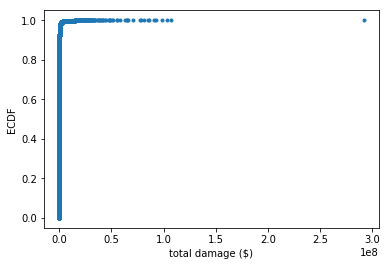

In [5]:
x, y = ecdf(df['totalDamage'])

_ = plt.plot(x, y, marker = '.', linestyle = 'none')
_ = plt.xlabel('total damage ($)')
_ = plt.ylabel('ECDF')

plt.show()

    Our ECDF curve shows two things: 1) what we already knew; that the data (at least on this predictor, total damages) is hard scewed the the left. But also, 2) that we have a serious outlier point. Intuition would tell us that total damages is probably correlated well with many of the other financial-related variables, so it's important to know what exactly that point is.

In [6]:
# let's go find that outlier!

df[df['totalDamage'] > 2.5e8].head() # produces record for disasterNumber 1604, zipcode 39520,
                                     # 'Bay Saint Louis', a city in MS after Katrina

,,,state,county,validRegistrations,totalInspected,noFemaInspectedDamage,approvedForFemaAssistance,totalApprovedIhpAmount,repairReplaceAmount,rentalAmount,otherNeedsAmount,...,incidentType,title,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseOutDate,disasterLength
disasterNumber,zipCode,city,,,,,,,,,,,,,,,,,,,,,
1604,39520,BAY SAINT LOUIS,MS,Hancock (County),18.0,9814.0,4868.0,9446.0,110043244.0,22683060.0,41842556.0,45517627.0,...,Hurricane,HURRICANE KATRINA,0,0,1,1,2005-08-29,2005-10-14 14:21:00,NaT,46 days 14:21:00.000000000


In [7]:
katrina = df.loc[1604] # Hurricane Katrina

katrina.shape

(1134, 36)

    Because of the massive amounts of zero's littering my data, perhaps we ought to consider each disaster in aggregate, as opposed to considering each individual city's record within each disaster. To do this, I created an aggregate data frame ('agg_df') using groupby:

In [8]:
group_df = df.iloc[:,2:23].groupby('disasterNumber').sum() # variables for which we need a sum aggregate

cat_vars = df.iloc[:,23:36].groupby('disasterNumber').first() # variables for which the data is consistent across records

agg_df = cat_vars.reset_index().merge(group_df.reset_index(), on = 'disasterNumber').set_index('disasterNumber')
agg_df.head(3)

,declarationDate,fyDeclared,disasterType,incidentType,title,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,...,totalMaxGrants,averageFemaInspectedDamage,totalDamage,femaInspectedDamageBetween1And10000,femaInspectedDamageBetween10001And20000,femaInspectedDamageBetween20001And30000,femaInspectedDamageGreaterThan30000,totalWithModerateDamage,totalWithMajorDamage,totalWithSubstantialDamage
disasterNumber,,,,,,,,,,,,,,,,,,,,,
1539,2004-08-13 17:30:00,2004,DR,Hurricane,TROPICAL STORM BONNIE AND HURRICANE CHARLEY,0,0,1,1,2004-08-11 09:00:00,...,145.0,1738228.0,300543524.0,44719.0,2405.0,447.0,974.0,0.0,0.0,0.0
1541,2004-08-26 23:15:00,2004,DR,Typhoon,"FLOODING, HIGH SURF, STORM SURGE, AND HIGH WIN...",1,1,1,1,2004-08-21 14:40:00,...,0.0,335578.0,6744470.0,632.0,88.0,10.0,3.0,0.0,0.0,0.0
1544,2004-09-03 18:30:00,2004,DR,Severe Storm(s),"SEVERE STORMS, FLOODING AND TORNADOES ASSOCIAT...",1,1,0,1,2004-08-30 14:14:00,...,4.0,139848.0,6523630.0,1689.0,104.0,36.0,9.0,0.0,0.0,0.0


Now, let's look at the data again:

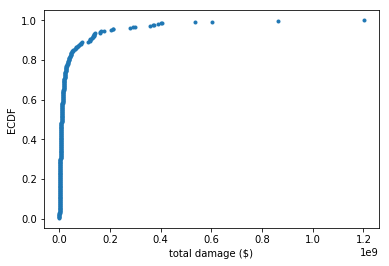

In [9]:
x, y = ecdf(agg_df['totalDamage'])

_ = plt.plot(x, y, marker = '.', linestyle = 'none')
_ = plt.xlabel('total damage ($)')
_ = plt.ylabel('ECDF')

plt.show()

We can edit this aggregate df even more by removing some of these significant outliers. We'll call this value-capped df 'agg_df_limit':

In [10]:
agg_df_limit = agg_df[agg_df['totalDamage']<60000000]
agg_df_limit.shape # this shows that we didn't lose too many disasters; only 46 of the 306 in the full data set

(260, 34)

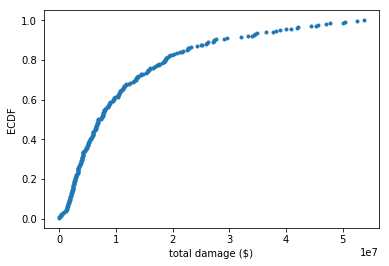

In [11]:
x, y = ecdf(agg_df_limit['totalDamage'])

_ = plt.plot(x, y, marker = '.', linestyle = 'none')
_ = plt.xlabel('total damage ($)')
_ = plt.ylabel('ECDF')

plt.show()

This distribution looks a lot better and will allow us to do more traditional analysis.  We not have 3 possible dataframes from which to draw our conclusions in the following exploration:

In [12]:
dfs = [df, agg_df, agg_df_limit]

print("1. 'df' : original df where records are indexed by disaster number, then zipcode, and then city; shape : " + str(df.shape))
print("2. 'agg_df' : aggregated df by disaster; financial information and counts are respectively summed; shape : " + str(agg_df.shape))
print("3. 'agg_df_limit' : aggregated df by disaster; financial information and counts are respectively summed, and disasters who total damage exceeds 60 million have been removed; shape : " + str(agg_df_limit.shape))

1. 'df' : original df where records are indexed by disaster number, then zipcode, and then city; shape : (92488, 36)
2. 'agg_df' : aggregated df by disaster; financial information and counts are respectively summed; shape : (306, 34)
3. 'agg_df_limit' : aggregated df by disaster; financial information and counts are respectively summed, and disasters who total damage exceeds 60 million have been removed; shape : (260, 34)


##### Can you count something interesting?

There are plenty of things of interest to count, but first, I wanted to look at the distribution of the different types of incidents we might be dealing with here. A histogram would naturally be the chart of choice here, but because the incident types of 'Hurricane' and 'Severe Storm(s)' dominate the options, this format seemed more readable.

In [13]:
print("Of the 92488 records, ")
for key, group_df in df.groupby('incidentType'):
    print("the group of type '{}' has {} rows ".format(key,len(group_df)))

Of the 92488 records, 
the group of type 'Earthquake' has 412 rows 
the group of type 'Fire' has 1871 rows 
the group of type 'Flood' has 7029 rows 
the group of type 'Hurricane' has 51454 rows 
the group of type 'Mud/Landslide' has 31 rows 
the group of type 'Other' has 7 rows 
the group of type 'Severe Storm(s)' has 29387 rows 
the group of type 'Tornado' has 416 rows 
the group of type 'Typhoon' has 1848 rows 
the group of type 'Volcano' has 33 rows 


Having the record counts is nice, but by taking advantage of these aggregate dataframes, we can also see how the incident types compare to one another, at least when it comes to total damage.

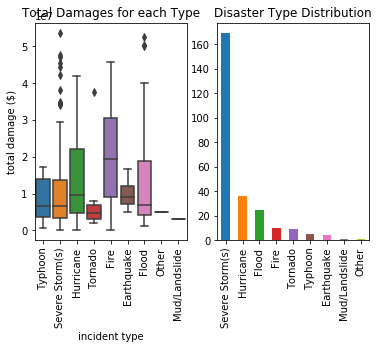

In [14]:
_ = plt.subplot(1,2,1)
_ = sns.boxplot(x='incidentType',y='totalDamage', data = agg_df_limit)
_ = plt.xlabel('incident type')
_ = plt.xticks(rotation = 90)
_ = plt.ylabel('total damage ($)')
_ = plt.title('Total Damages for each Type')

_ = plt.subplot(1,2,2)
_ = agg_df_limit.incidentType.value_counts().plot(kind = 'bar')
_ = plt.xticks(rotation = 90)
_ = plt.title('Disaster Type Distribution')

plt.show()

##### Can you find trends (e.g. high, low, increasing, decreasing, anomalies)?

We find one trend here with individual registrations. For some reason, which the data may or may not be able to tell us, registrations begin to really increase, exponentially even, after 2012. Best guess? Federal legislation. 

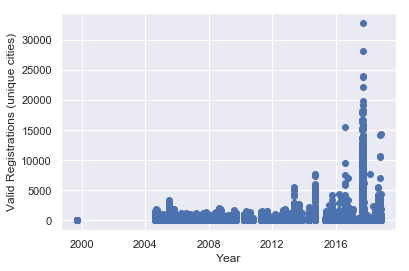

In [15]:
import matplotlib.dates as dlt

sns.set()
declarationDates = dlt.date2num(df.declarationDate)
_ = plt.plot_date(declarationDates, df['validRegistrations'])
_ = plt.xlabel('Year')
_ = plt.ylabel('Valid Registrations (unique cities)')
plt.show()

##### Can you make a bar plot or histogram?

    If we use that limited aggregate DataFrame, 'agg_df_limit', we can get a reasonably shaped histogram of our 'totalDamage' variable across disasters.

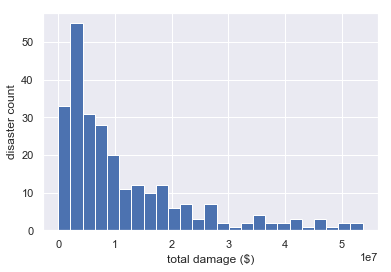

In [16]:
_ = plt.hist('totalDamage', data = agg_df_limit, bins = 25)
_ = plt.xlabel('total damage ($)')
_ = plt.ylabel('disaster count')
plt.show()

##### Can you compare two related quantities?

     With many of these variables, correlation should be intuitive, as many of them are essentially various ways of describing how expensive any one disaster might have been. But we have some non-financial numbers to play with as well, such as valid registration count and total approved for assistance.  When I first looked up the total damage outlier (our city demolished by Katrina, Bay Saint Louis), I noticed Valid Registrations was a paltry 18. Now, we don't have census information for each city recorded, but we can still look to draw correlations based on this valid registration count.

In [17]:
def pearson_r(x, y):
    corr_matrix = np.corrcoef(x, y)
    return corr_matrix[0,1]

In [18]:
pearson_r(agg_df['validRegistrations'],agg_df['approvedForFemaAssistance'])

0.7729307363493447

In [19]:
grants_list = ['approvedBetween1And10000','approvedBetween10001And25000','approvedBetween25001AndMax','totalMaxGrants']

# we'll be using this series of grant sizes more than once, so it's best to just make a list object to reference

programs_list = ['ihProgramDeclared','iaProgramDeclared','paProgramDeclared','hmProgramDeclared']

# we'll be using this series of programs more than once as well, so it's best to just make a list object to reference

In [20]:
print("Pearson correlations : ")
for grant_category in grants_list:
    print("valid registrations and "+str(grant_category) + " : " 
          + str(pearson_r(agg_df['validRegistrations'],agg_df[grant_category])))

Pearson correlations : 
valid registrations and approvedBetween1And10000 : 0.9716985423426233
valid registrations and approvedBetween10001And25000 : 0.4769441778602019
valid registrations and approvedBetween25001AndMax : 0.2922492617287202
valid registrations and totalMaxGrants : 0.17778012445287023


##### Can you make a scatterplot?

We have grants of four different levels being distributed to owners and renter for each record. A scatter plot with subplots would be a nice way to look at these levels all together to see if there are trends:

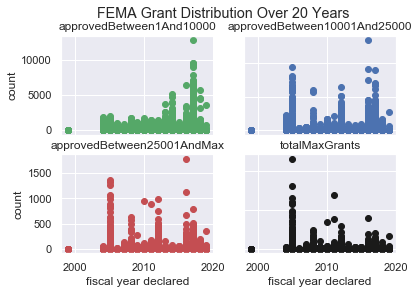

In [21]:
f, axarr = plt.subplots(2, 2)
axarr[0, 0].scatter(x = df['fyDeclared'], y = df[grants_list[0]], color = 'g')
axarr[0, 0].set_title(str(grants_list[0]))
axarr[0, 1].scatter(x = df['fyDeclared'], y = df[grants_list[1]], color = 'b')
axarr[0, 1].set_title(str(grants_list[1]))
axarr[1, 0].scatter(x = df['fyDeclared'], y = df[grants_list[2]], color = 'r')
axarr[1, 0].set_title(str(grants_list[2]))
axarr[1, 1].scatter(x = df['fyDeclared'], y = df[grants_list[3]], color = 'k')
axarr[1, 1].set_title(str(grants_list[3]))
for ax in axarr.flat:
    ax.set(xlabel='fiscal year declared', ylabel='count')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axarr.flat:
    ax.label_outer()
f.suptitle('FEMA Grant Distribution Over 20 Years')
plt.show()


    The previous subplots show us something interesting indeed: grant distribution, especially passed the minimum level, is dominated by spikes in particular years. Before further investigation, we see that the years 2005, 2008, 2012, and 2016/17 have the lion share of the data. This of course points to specific disasters each time. For example, we know Hurricane Katrina is responsible (perhaps almost soley responsible) for the grants FEMA gave out in 2005. Further investigation of these other years might give us insights into whether we are warranted in calling this an every-4-year-pattern.

### Looking at the plots, what are some insights you can make? Do you see any correlations? Is there a hypothesis you’d like to investigate further? What other questions do the insights lead you to ask?

    Correlations inevitably exist as most of these predictors revolve around how much damage was done, but which predictors tell us the most is the pertinent question. The grant information is the sum of both parties. We'll need to take information like this into account when deciding which numbers are most important.
    
    As far as future hypotheses, this 'every-4-year-pattern' has become an interesting question. But we also want to stay the course on assessing FEMA's mitigation protocols by basing it on money spent over time. The hypothesis around this, currently, is that FEMA is spending/giving/awarding less money despite no change in disaster damages.
    
    For my second hypothesis, I believe that how severely regions were previously effected by disasters tell us the most about how they will be effected in the future. In other words, we perhaps ought to ignore other factors, such as geography and socioeconomics when prioritizing regions, and use previous disaster effects to rate and to rank regions for mitigation effort priority.

### Is there a narrative or a way of presenting the insights using text and plots that tells a compelling story? What are some other trends/relationships you think will make the story more complete?

    What has become most apparent is that we will need to manipulate the data to show some of the things we want to show.  All of the zeroes that fill the data sets pull our data in a way that is deceiving--is this cause for concern? Are simple summary statistics not telling the whole story? That's our primary angle right now.
    
    While this might be outside the scope of this project, socioeconomic and demographic information would really add to the questions we might be able to ask. It's no secret that Katrina ravaged poor cities in an already poor state. What is the story there? And does it happen more often than we might be led to believe?

In [30]:
agg_df.to_csv('aggregate_FEMA.csv',sep = '\t', index = 'disasterNumber')